# **Import Library**

In [1]:
from pathlib import Path
import random
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, fft
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

# **Create Sequences**

In [2]:
data_path = Path.cwd().parent / 'data' / 'cleaned_data' / 'cleaned_wind_turbine_data.csv'

df = pd.read_csv(data_path)

sequence_length = 500 

X, y = [], []

for i in range(0, len(df), sequence_length):
    seq = df.iloc[i:i + sequence_length]
    if len(seq) == sequence_length:
        X.append(seq[['amplitude', 'wind_speed']].values)
        y.append(seq['label'].iloc[0])

X = np.array(X)
y = np.array(y)

print(f"Created {len(X)} sequences, each with {sequence_length} time steps")
print("Number of sequences per class:")

class_counts = pd.Series(y).value_counts().sort_index()
for label, count in class_counts.items():
    print(f"Label {label}: {count} sequences")

Created 35 sequences, each with 500 time steps
Number of sequences per class:
Label 0: 7 sequences
Label 1: 7 sequences
Label 2: 7 sequences
Label 3: 7 sequences
Label 4: 7 sequences


In [3]:
print("\nShape Overview:")
print("X.shape =", X.shape)
print("y.shape =", y.shape)

print("\nSingle Sequence:")
print("X[0].shape =", X[0].shape)
print("X[0] =", X[0])

print("\nFirst Time Step:")
print("X[0][0].shape =", X[0][0].shape)
print("X[0][0] =", X[0][0])

print("\nFirst Label:")
print("y[0] =", y[0])


Shape Overview:
X.shape = (35, 500, 2)
y.shape = (35,)

Single Sequence:
X[0].shape = (500, 2)
X[0] = [[ 3.2200e-04  4.5000e+00]
 [-1.3920e-02  4.5000e+00]
 [ 6.3230e-02  4.5000e+00]
 [-4.7600e-03  4.5000e+00]
 [ 5.1960e-02  4.5000e+00]
 [ 7.7090e-02  4.5000e+00]
 [ 2.1990e-02  4.5000e+00]
 [-7.9200e-05  4.5000e+00]
 [ 3.1330e-02  4.5000e+00]
 [ 4.4870e-02  4.5000e+00]
 [ 1.1030e-02  4.5000e+00]
 [-4.2700e-03  4.5000e+00]
 [-1.6430e-02  4.5000e+00]
 [-5.5240e-02  4.5000e+00]
 [-6.7770e-02  4.5000e+00]
 [ 1.1157e-01  4.5000e+00]
 [ 7.6500e-03  4.5000e+00]
 [-3.7690e-02  4.5000e+00]
 [-1.2374e-01  4.5000e+00]
 [-3.5780e-02  4.5000e+00]
 [-3.6180e-02  4.5000e+00]
 [ 1.5060e-02  4.5000e+00]
 [-3.8900e-03  4.5000e+00]
 [-2.9160e-02  4.5000e+00]
 [-1.9230e-02  4.5000e+00]
 [ 3.0200e-02  4.5000e+00]
 [ 8.5310e-02  4.5000e+00]
 [ 9.0140e-02  4.5000e+00]
 [ 1.0689e-01  4.5000e+00]
 [-2.3400e-03  4.5000e+00]
 [-4.6900e-03  4.5000e+00]
 [ 2.9880e-02  4.5000e+00]
 [-8.4000e-03  4.5000e+00]
 [-2.1

# **Data Augmentation for Sequences**

In [4]:
noise_factor = 0.02
shift_max = 50
scale_range = (0.9, 1.1)
num_augments = 50

X_augmented = []
y_augmented = []

for seq, label in zip(X, y):
    for _ in range(num_augments):
        noisy = seq + np.random.normal(0, noise_factor, seq.shape)
        
        shift = random.randint(-shift_max, shift_max)
        shifted = np.roll(noisy, shift, axis=0)
        
        scale = random.uniform(*scale_range)
        scaled = shifted.copy()
        scaled[:, 0] *= scale
        
        if random.random() > 0.5:
            scaled = np.flip(scaled, axis=0)
        
        X_augmented.append(scaled)
        y_augmented.append(label)

X_augmented = np.array(X_augmented)
y_augmented = np.array(y_augmented)

print(f"Created {len(X_augmented)} augmented sequences, each with {sequence_length} time steps")
print("Number of augmented sequences per class:")

class_counts = pd.Series(y_augmented).value_counts().sort_index()
for label, count in class_counts.items():
    print(f"Label {label}: {count} sequences")

Created 1750 augmented sequences, each with 500 time steps
Number of augmented sequences per class:
Label 0: 350 sequences
Label 1: 350 sequences
Label 2: 350 sequences
Label 3: 350 sequences
Label 4: 350 sequences


In [5]:
print("\nShape Overview:")
print("X_augmented.shape =", X_augmented.shape)
print("y_augmented.shape =", y_augmented.shape)

print("\nSingle Sequence:")
print("X_augmented[0].shape =", X_augmented[0].shape)
print("X_augmented[0] =", X_augmented[0])

print("\nFirst Time Step:")
print("X_augmented[0][0].shape =", X_augmented[0][0].shape)
print("X_augmented[0][0] =", X_augmented[0][0])

print("\nFirst Label:")
print("y_augmented[0] =", y_augmented[0])


Shape Overview:
X_augmented.shape = (1750, 500, 2)
y_augmented.shape = (1750,)

Single Sequence:
X_augmented[0].shape = (500, 2)
X_augmented[0] = [[ 2.10214938e-03  4.49440210e+00]
 [ 7.89822425e-02  4.50488067e+00]
 [-7.21121648e-02  4.51348572e+00]
 [-3.83140142e-02  4.52307486e+00]
 [-9.41979463e-03  4.48447580e+00]
 [ 9.49048753e-03  4.53501483e+00]
 [ 2.79718786e-03  4.50452922e+00]
 [ 5.04514534e-02  4.48633304e+00]
 [ 4.78390654e-02  4.51766518e+00]
 [ 2.47638871e-02  4.54702824e+00]
 [ 2.18856556e-02  4.49527904e+00]
 [ 7.39846719e-02  4.48817121e+00]
 [ 5.36720457e-02  4.49980885e+00]
 [ 1.64735411e-02  4.46521331e+00]
 [ 8.45381919e-02  4.49688708e+00]
 [-9.78526421e-03  4.50350228e+00]
 [ 1.38915142e-02  4.48177149e+00]
 [-2.93456237e-02  4.55473223e+00]
 [ 7.53547137e-02  4.52587858e+00]
 [ 8.15106276e-02  4.45451625e+00]
 [ 2.22586058e-03  4.48646213e+00]
 [ 2.74083903e-02  4.53294480e+00]
 [-3.82133223e-02  4.49686745e+00]
 [ 4.59878144e-02  4.53317905e+00]
 [ 7.64585998

# **Extract New Features**

In [6]:
def extract_new_features(sequence):
    amplitude = sequence[:, 0]
    wind_speed = sequence[:, 1]

    mean_amplitude = np.mean(amplitude)
    std_amplitude = np.std(amplitude)
    max_amplitude = np.max(amplitude)
    min_amplitude = np.min(amplitude)
    skew_amplitude = stats.skew(amplitude)
    kurtosis_amplitude = stats.kurtosis(amplitude)

    mean_wind_speed = np.mean(wind_speed)
    std_wind_speed = np.std(wind_speed)

    amplitude_diff = np.diff(amplitude)
    amplitude_variation_ratio = (
        np.std(amplitude_diff) / (np.mean(np.abs(amplitude)) + 1e-10)
    )

    time_features = [
        mean_amplitude,
        std_amplitude,
        max_amplitude,
        min_amplitude,
        skew_amplitude,
        kurtosis_amplitude,
        mean_wind_speed,
        std_wind_speed,
        amplitude_variation_ratio
    ]

    fft_vals = np.abs(fft.fft(amplitude))[:len(amplitude)//2]
    fft_probs = fft_vals / (np.sum(fft_vals) + 1e-10)

    peak_freq = np.argmax(fft_vals)
    spectral_energy = np.sum(fft_vals ** 2)
    spectral_entropy = -np.sum(fft_probs * np.log2(fft_probs + 1e-10))

    frequency_features = [
        peak_freq,
        spectral_energy,
        spectral_entropy
    ]

    features = time_features + frequency_features
    return np.array(features)

X_features = np.array([extract_new_features(sequence) for sequence in X_augmented])

In [7]:
print("\nShape Overview:")
print("X_features.shape =", X_features.shape)
print("y_augmented.shape =", y_augmented.shape)

print("\nSingle Sample:")
print("X_features[0].shape =", X_features[0].shape)
print("X_features[0] =", X_features[0])

print("\nSingle Feature Value:")
print("X_features[0][0].shape =", np.shape(X_features[0][0]))
print("X_features[0][0] =", X_features[0][0])

print("\nFirst Label:")
print("y_augmented[0] =", y_augmented[0])


Shape Overview:
X_features.shape = (1750, 12)
y_augmented.shape = (1750,)

Single Sample:
X_features[0].shape = (12,)
X_features[0] = [-7.82766815e-05  5.23211779e-02  2.57478797e-01 -1.36595006e-01
  8.98314980e-01  2.73638523e+00  4.49821900e+00  2.03784752e-02
  1.77321436e+00  2.50000000e+01  3.42102563e+02  7.74916179e+00]

Single Feature Value:
X_features[0][0].shape = ()
X_features[0][0] = -7.827668146910427e-05

First Label:
y_augmented[0] = 2


# **Scaler & PCA**

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)

pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_scaled)

print("Dimensionality Reduction:")
print(f"Before PCA: {X_scaled.shape[1]} dimensions")
print(f"After PCA: {X_reduced.shape[1]} dimensions (95% variance retained)")

print("\nExplained Variance Ratio per Component:")
for i, var in enumerate(pca.explained_variance_ratio_, start=1):
    print(f"PC{i}: {var:.4f}")

Dimensionality Reduction:
Before PCA: 12 dimensions
After PCA: 9 dimensions (95% variance retained)

Explained Variance Ratio per Component:
PC1: 0.3186
PC2: 0.2004
PC3: 0.1112
PC4: 0.0835
PC5: 0.0757
PC6: 0.0639
PC7: 0.0482
PC8: 0.0449
PC9: 0.0313


In [9]:
print("Shape Overview:")
print("X_scaled.shape  =", X_scaled.shape)
print("X_reduced.shape =", X_reduced.shape)

print("\nSingle Scaled Sample:")
print("X_scaled[0].shape =", X_scaled[0].shape)
print("X_scaled[0] =", X_scaled[0])

print("\nSingle Reduced Sample:")
print("X_reduced[0].shape =", X_reduced[0].shape)
print("X_reduced[0] =", X_reduced[0])

feature_names = [
    "mean_amplitude",
    "std_amplitude",
    "max_amplitude",
    "min_amplitude",
    "skew_amplitude",
    "kurtosis_amplitude",
    "mean_wind_speed",
    "std_wind_speed",
    "amplitude_variation_ratio",
    "peak_freq",
    "spectral_energy",
    "spectral_entropy"
]

print("\nPCA Component Loadings:")
for i, component in enumerate(pca.components_, start=1):
    print(f"\nPC{i}:")
    for name, weight in zip(feature_names, component):
        print(f"  {name:30s}: {weight:+.4f}")

Shape Overview:
X_scaled.shape  = (1750, 12)
X_reduced.shape = (1750, 9)

Single Scaled Sample:
X_scaled[0].shape = (12,)
X_scaled[0] = [-1.61454413  0.27859495  1.57754755  0.01300184  1.93073725  3.30677494
  0.68570158  0.68616036  0.64616096 -0.08268098  0.11570061  1.5363541 ]

Single Reduced Sample:
X_reduced[0].shape = (9,)
X_reduced[0] = [ 1.36744127  2.68981171 -1.41617474  0.71107232  3.10700376  0.27194298
  0.24705094 -1.13805306 -0.63810677]

PCA Component Loadings:

PC1:
  mean_amplitude                : +0.0542
  std_amplitude                 : +0.4715
  max_amplitude                 : +0.4539
  min_amplitude                 : -0.3892
  skew_amplitude                : +0.2114
  kurtosis_amplitude            : +0.1609
  mean_wind_speed               : +0.0717
  std_wind_speed                : +0.0195
  amplitude_variation_ratio     : -0.0632
  peak_freq                     : -0.2097
  spectral_energy               : +0.4670
  spectral_entropy              : -0.2739

PC2:


# **Dataset Splitting**

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X_reduced,
    y_augmented,
    test_size=0.2,
    random_state=42,
    stratify=y_augmented
)

print(f"Training Feature Shape: {X_train.shape}")
print(f"Test Feature Shape: {X_test.shape}")

print(f"\nTraining Label Shape: {y_train.shape}")
print(f"Test Label Shape: {y_test.shape}")

Training Feature Shape: (1400, 9)
Test Feature Shape: (350, 9)

Training Label Shape: (1400,)
Test Label Shape: (350,)


# **Stratified Cross-Validation**

In [11]:
def get_stratified_folds(X, y, n_splits=5, random_state=42):
    skf = StratifiedKFold(
        n_splits=n_splits,
        shuffle=True,
        random_state=random_state
    )
    return list(skf.split(X, y))

cv_folds = get_stratified_folds(X_train, y_train, n_splits=5)

print(f"Number of CV folds: {len(cv_folds)}")

train_idx_first = cv_folds[0][0][:10]
val_idx_first = cv_folds[0][1][:10]

print("Example Indices (First Fold):")
print("\n--> Train Indices:")
for idx in train_idx_first:
    print(f"Train[{idx}]")

print("\n--> Validation Indices:")
for idx in val_idx_first:
    print(f"Validation[{idx}]")

Number of CV folds: 5
Example Indices (First Fold):

--> Train Indices:
Train[1]
Train[2]
Train[3]
Train[4]
Train[6]
Train[7]
Train[8]
Train[10]
Train[11]
Train[13]

--> Validation Indices:
Validation[0]
Validation[5]
Validation[9]
Validation[12]
Validation[16]
Validation[21]
Validation[24]
Validation[25]
Validation[33]
Validation[39]


In [12]:
for i, (train_idx, val_idx) in enumerate(cv_folds, start=1):
    y_train_fold = y_train[train_idx]
    y_val_fold = y_train[val_idx]
    
    train_counter = Counter(y_train_fold)
    val_counter = Counter(y_val_fold)
    
    print(f"Fold {i}: Train Samples is {len(train_idx)}, Validation Samples is {len(val_idx)}")
    
    print("\n--> Train Label Distribution:")
    for label, count in sorted(train_counter.items()):
        print(f"Label {label}: {count} samples")

    print("\n--> Validation Label Distribution:")
    for label, count in sorted(val_counter.items()):
        print(f"Label {label}: {count} samples")

    print("\n")

Fold 1: Train Samples is 1120, Validation Samples is 280

--> Train Label Distribution:
Label 0: 224 samples
Label 1: 224 samples
Label 2: 224 samples
Label 3: 224 samples
Label 4: 224 samples

--> Validation Label Distribution:
Label 0: 56 samples
Label 1: 56 samples
Label 2: 56 samples
Label 3: 56 samples
Label 4: 56 samples


Fold 2: Train Samples is 1120, Validation Samples is 280

--> Train Label Distribution:
Label 0: 224 samples
Label 1: 224 samples
Label 2: 224 samples
Label 3: 224 samples
Label 4: 224 samples

--> Validation Label Distribution:
Label 0: 56 samples
Label 1: 56 samples
Label 2: 56 samples
Label 3: 56 samples
Label 4: 56 samples


Fold 3: Train Samples is 1120, Validation Samples is 280

--> Train Label Distribution:
Label 0: 224 samples
Label 1: 224 samples
Label 2: 224 samples
Label 3: 224 samples
Label 4: 224 samples

--> Validation Label Distribution:
Label 0: 56 samples
Label 1: 56 samples
Label 2: 56 samples
Label 3: 56 samples
Label 4: 56 samples


Fold 4:

# **SVM Hyperparameter Tuning**

In [13]:
param_grid = {
    "C": [0.01, 0.1, 1, 10, 100],
    "gamma": ["scale", 0.001, 0.01, 0.1, 1],
    "kernel": ["rbf"]
}

svm = SVC(random_state=42)

grid_search = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    cv=cv_folds,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

grid_search.fit(X_train, y_train)

svm_model = grid_search.best_estimator_

print("\n--> Best Model")
print("Final Selected Model:", svm_model)
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Cross-Validation (Validation) Accuracy:", grid_search.best_score_)

print("\n--> All Grid Search Results")
for params, mean_train, mean_test in zip(
        grid_search.cv_results_["params"],
        grid_search.cv_results_["mean_train_score"],
        grid_search.cv_results_["mean_test_score"]):
    print(f"Params: {params}, Mean Train Accuracy: {mean_train:.4f}, Mean CV Accuracy: {mean_test:.4f}")

Fitting 5 folds for each of 25 candidates, totalling 125 fits

--> Best Model
Final Selected Model: SVC(C=10, random_state=42)
Best Hyperparameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best Cross-Validation (Validation) Accuracy: 0.9171428571428573

--> All Grid Search Results
Params: {'C': 0.01, 'gamma': 'scale', 'kernel': 'rbf'}, Mean Train Accuracy: 0.6713, Mean CV Accuracy: 0.6464
Params: {'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}, Mean Train Accuracy: 0.5611, Mean CV Accuracy: 0.5429
Params: {'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}, Mean Train Accuracy: 0.5779, Mean CV Accuracy: 0.5621
Params: {'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}, Mean Train Accuracy: 0.6748, Mean CV Accuracy: 0.6514
Params: {'C': 0.01, 'gamma': 1, 'kernel': 'rbf'}, Mean Train Accuracy: 0.9227, Mean CV Accuracy: 0.7743
Params: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}, Mean Train Accuracy: 0.7961, Mean CV Accuracy: 0.7686
Params: {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}, Mean Train Accur

# **Evaluate Model**


Test Accuracy: 0.9057

Classification Report:
                             precision    recall  f1-score   support

    Blade Healthy Condition       1.00      1.00      1.00        70
Blade Surface Erosion Fault       0.90      0.81      0.86        70
          Blade Crack Fault       0.91      0.90      0.91        70
 Blade Mass Imbalance Fault       0.88      0.91      0.90        70
          Blade Twist Fault       0.84      0.90      0.87        70

                   accuracy                           0.91       350
                  macro avg       0.91      0.91      0.91       350
               weighted avg       0.91      0.91      0.91       350



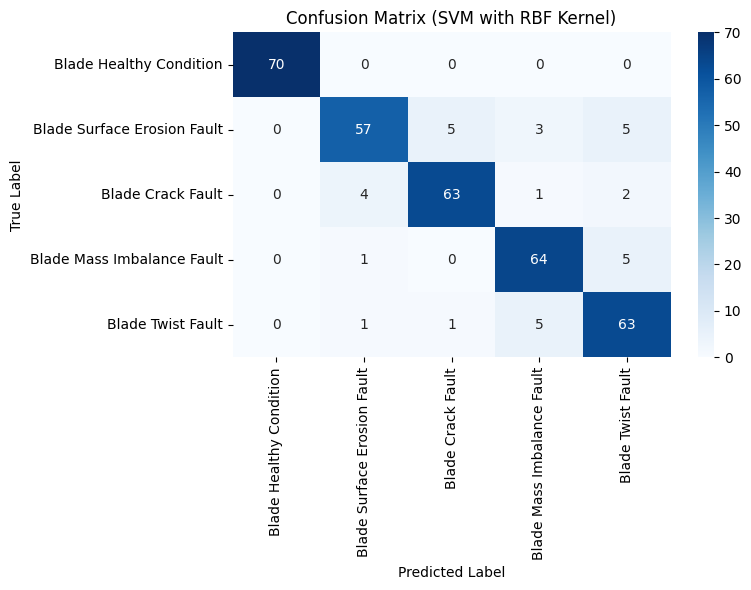

In [14]:
y_pred = svm_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {accuracy:.4f}")

class_names = [
    "Blade Healthy Condition",
    "Blade Surface Erosion Fault",
    "Blade Crack Fault",
    "Blade Mass Imbalance Fault",
    "Blade Twist Fault"
]

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.title("Confusion Matrix (SVM with RBF Kernel)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig("../picture/confusion_matrix.png")
plt.show()

# **Save Scaler, PCA & Model**

In [15]:
scaler_path = Path.cwd().parent / 'model' / 'feature_scaler.pkl'
pca_path = Path.cwd().parent / 'model' / 'pca_transformer.pkl'
model_path = Path.cwd().parent / 'model' / 'svm_rbf_model.pkl'

joblib.dump(X_scaled, scaler_path)
joblib.dump(X_reduced, pca_path)
joblib.dump(svm_model, model_path)

print("Scaler Saved To: model/feature_scaler.pkl")
print("PCA Saved To: model/pca_transformer.pkl")
print("Trained Model Saved To: model/svm_rbf_model.pkl")

Scaler Saved To: model/feature_scaler.pkl
PCA Saved To: model/pca_transformer.pkl
Trained Model Saved To: model/svm_rbf_model.pkl
